In [1]:
import arviz as az
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from corner import corner
from mpl_toolkits.mplot3d import axes3d
import gapipes as gp
import kinesis as kn

kn.set_mpl_style()

In [2]:
from scipy import stats

In [3]:
np.random.seed(8439271)

In [4]:
def make_grid_cluster(
    ra,
    dec,
    d,
    v0,
    degsize=5.0,
    errfrac=0.05,
    Nrv=None,
    cl_params={},
    N=100,
    shape="sphere",
):
    """
    shape (str): 'sphere' or 'sheet'
    """
    b0 = coord.ICRS(ra * u.deg, dec * u.deg, d * u.pc).cartesian.xyz.value
    sigma = 0.1

    if shape == "sheet":
        ra_bins = np.linspace(ra - degsize, ra + degsize, 11)
        dec_bins = np.linspace(dec - degsize, dec + degsize, 11)
        d_bins = [d]
        ra_grid, dec_grid, d_grid = np.meshgrid(ra_bins, dec_bins, d_bins)
        ra_grid = ra_grid.ravel()
        dec_grid = dec_grid.ravel()
        d_grid = d_grid.ravel()
        memicrs = coord.ICRS(ra_grid * u.deg, dec_grid * u.deg, d_grid * u.pc)

        cl = kn.Cluster(v0, sigma, b0=b0, **cl_params,).sample_at(memicrs)
    elif shape == "sphere":
        cl = kn.Cluster(v0, sigma, b0=b0, **cl_params).sample_sphere(N, Rmax=5)
    else:
        raise ValueError("`shape` must be one of 'sphere' or 'sheet'")

    # noisify
    cov = np.array(
        [
            np.diag(X)
            for X in np.abs(cl.members.truth[["parallax", "pmra", "pmdec"]].values)
            * errfrac ** 2
        ]
    )
    cov[:, 0, 0] /= 25.0
    if Nrv is None:
        irv = np.arange(cl.N)
    else:
        irv = np.random.choice(np.arange(cl.N), size=Nrv, replace=False)
    rv_error = np.array([np.nan] * cl.N)
    rv_error[irv] = errfrac * np.abs(cl.members.truth["radial_velocity"][irv].values)
    # rv_error = [0.001]*cl1.N
    cl.members.observe(cov=cov, rv_error=rv_error)
    return cl

In [5]:
def fit(cluster):
    D = cluster.members.observed

    irv = np.where(D["radial_velocity"].notnull().values)[0]
    standata = dict(
        ra=D["ra"].values,
        dec=D["dec"].values,
        a=D[["parallax", "pmra", "pmdec"]].values,
        C=D.g.make_cov(),
        N=len(D),
        Nrv=D["radial_velocity"].notnull().sum(),
        irv=np.where(D["radial_velocity"].notnull())[0],
        rv=D["radial_velocity"].values[irv],
        rv_error=D["radial_velocity_error"].values[irv],
        include_T=1,
        b0=cluster.b0,
    )

    def init():
        return dict(
            d=1e3 / D["parallax"], v0=[5, 0, 7], sigv=1.0, T=np.zeros(shape=(1, 3, 3)),
        )

    r = model.optimizing(data=standata, init=init)
    map_soln = r.copy()
    map_soln.update(kn.decompose_T(map_soln["T_param"]))

    r = model.sampling(data=standata, init=init)
    return map_soln, r

In [6]:
def plot_xv(D):
    fig, axes = plt.subplots(3,3, sharex='col', sharey='row')
    for row, y in zip(axes, ['d_x','d_y','d_z']):
        for cax, x in zip(row, ['x','y','z']):
            X = getattr(D.g.icrs.cartesian, x)
            Y = getattr(D.g.icrs.velocity, y)
            cax.scatter(X, Y, s=4, c=D.dec)

In [7]:
model = kn.get_model('general_model')# recompile=True)

INFO:kinesis.models:Reading model from disk


In [8]:
v0 = np.array([5., 5., 7.07106781])*1
sphere2 = dict(
    pos1=make_grid_cluster(45, 45, 100, v0, Nrv=2),
    pos2=make_grid_cluster(300, 45, 100, v0, Nrv=2),
    pos3=make_grid_cluster(340, -65, 100, v0, Nrv=2),
)

sphererv = dict(
    pos1=make_grid_cluster(45, 45, 100, v0),
    pos2=make_grid_cluster(300, 45, 100, v0),
    pos3=make_grid_cluster(340, -65, 100, v0),
)

sheet2 = dict(
    pos1=make_grid_cluster(45, 45, 100, v0, Nrv=2, shape="sheet"),
    pos2=make_grid_cluster(300, 45, 100, v0, Nrv=2, shape="sheet"),
    pos3=make_grid_cluster(340, -65, 100, v0, Nrv=2, shape="sheet"),
)

sheetrv = dict(
    pos1=make_grid_cluster(45, 45, 100, v0, shape="sheet"),
    pos2=make_grid_cluster(300, 45, 100, v0, shape="sheet"),
    pos3=make_grid_cluster(340, -65, 100, v0, shape="sheet"),
)

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/home/soh/.conda/envs/nitro/lib/python3.7/site-packages/matplotlib/quiver.py:680: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/soh/.conda/envs/nitro/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


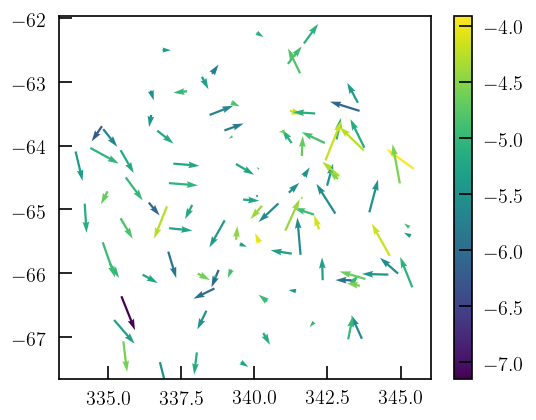

In [7]:
D = sphererv['pos3'].members.observed
q = plt.quiver(D['ra'],D['dec'],D['pmra']-np.median(D['pmra']),D['pmdec']-np.median(D['pmdec']),
                                                    D['radial_velocity'].values)
plt.colorbar(q)
sel = D['radial_velocity'].isna()
plt.quiver(D['ra'][sel],D['dec'][sel],D['pmra'][sel],D['pmdec'][sel],);

In [ ]:
cl6 = make_grid_cluster(340, -65, 500, v0, cl_params=dict(omegas=[0,0,0]), N=1000)
D = cl6.members.observed
plot_xv(cl6.members.observed)

In [ ]:
plot_xv(cl6.members.truth)

In [9]:
def get_result(cluster_dict):    
    result = dict()
    for k, cl in cluster_dict.items():
        map_soln, stanfit = fit(cl)
        result[k]= dict(
            cl=cl,
            map_soln=map_soln,
            stanfit=stanfit,
            azfit=az.from_pystan(stanfit))
    return result

In [10]:
%time sheet2_result = get_result(sheet2)
%time sheetrv_result = get_result(sheetrv)

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 3.54 s, sys: 3.54 s, total: 7.08 s
Wall time: 3min 45s


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 4.2 s, sys: 5.11 s, total: 9.31 s
Wall time: 3min 47s


In [11]:
%time sphere2_result = get_result(sphere2)
%time sphererv_result = get_result(sphererv)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 2.93 s, sys: 6.64 s, total: 9.57 s
Wall time: 3min 3s


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 3.81 s, sys: 16.5 s, total: 20.3 s
Wall time: 7min 22s


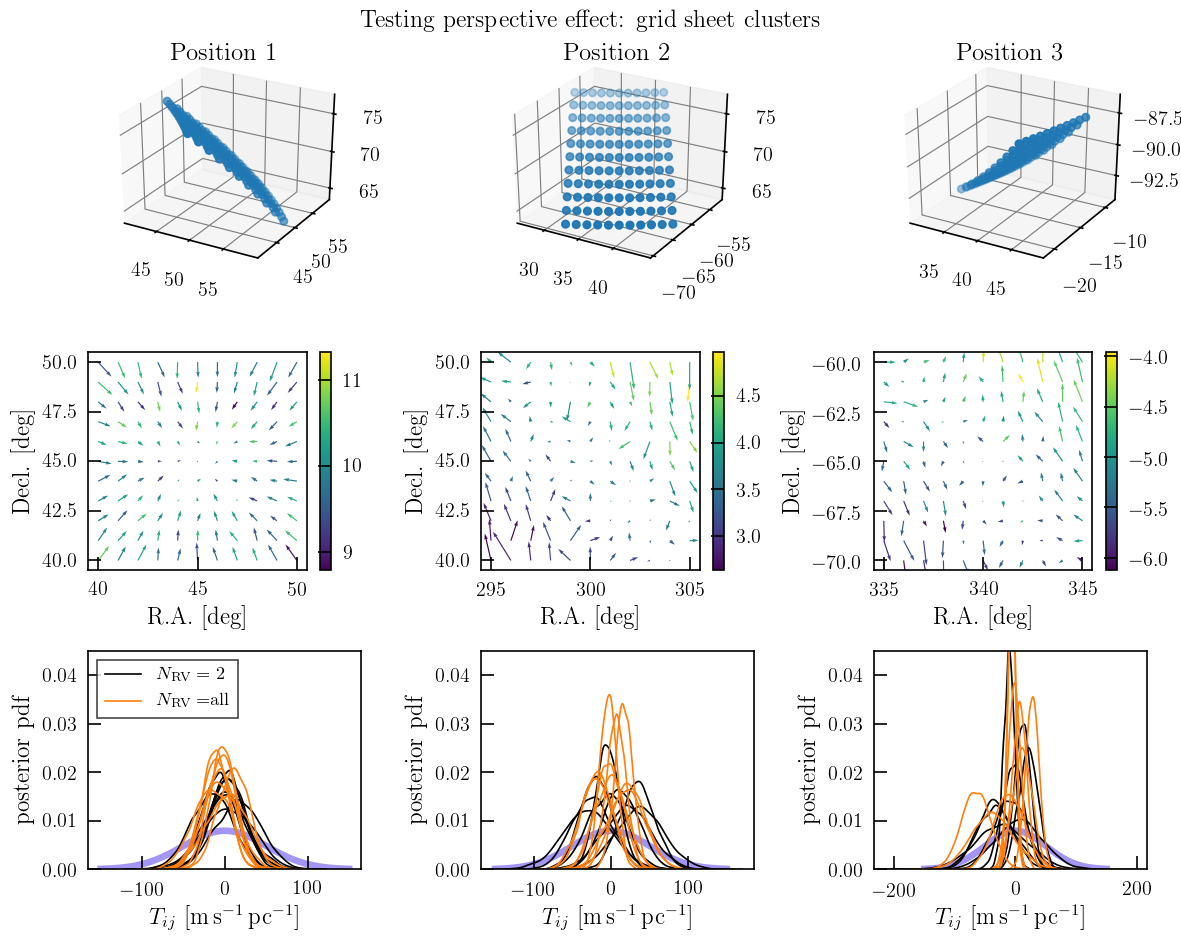

In [15]:
fig = plt.figure(figsize=(10, 8))
grid = fig.add_gridspec(3, 3)
axes1 = [fig.add_subplot(grid[0, i], projection="3d") for i in range(3)]
axes2 = [fig.add_subplot(grid[1, i]) for i in range(3)]
axes3 = [fig.add_subplot(grid[2, i]) for i in range(3)]

fig.suptitle("Testing perspective effect: grid sheet clusters")
for cax1, cax2, cax3, pos in zip(axes1, axes2, axes3, ["pos1", "pos2", "pos3"]):
    cl = sheet2_result[pos]["cl"]
    D = cl.members.truth
    xyz = D.g.icrs.cartesian.xyz
    vxyz = D.g.icrs.velocity.d_xyz.value
    cax1.scatter(*xyz)
    cax1.set_title("Position {}".format(pos[-1]), size=15)

    cl = sheetrv_result[pos]["cl"]
    D = cl.members.observed
    q = cax2.quiver(
        D["ra"],
        D["dec"],
        D["pmra"] - np.median(D["pmra"]),
        D["pmdec"] - np.median(D["pmdec"]),
        D["radial_velocity"].values,
    )

    Tij = sheet2_result[pos]["stanfit"]["T_param"].reshape((-1, 9))
    for tt in Tij.T:
        sns.kdeplot(
            tt, c="k", ax=cax3,
        )
    Tij = sheetrv_result[pos]["stanfit"]["T_param"].reshape((-1, 9))
    for tt in Tij.T:
        sns.kdeplot(
            tt, c="C1", ax=cax3,
        )
    cax3.set(
        xlabel=r"$T_{ij}$ [$\mathrm{m}\,\mathrm{s}^{-1}\,\mathrm{pc}^{-1}$]",
        ylabel="posterior pdf",
        ylim=(None, 0.045),
    )

    cax2.set(xlabel="R.A. [deg]", ylabel="Decl. [deg]")
    plt.colorbar(q, ax=cax2)
    if pos == "pos1":
        (l1,) = cax3.plot([], [], "k-")
        (l2,) = cax3.plot([], [], "C1-")
        cax3.legend(
            (l1, l2),
            (r"$N_\mathrm{RV}=2$", r"$N_\mathrm{RV}=$all"),
            loc="upper left",
            fontsize=11,
        )
    x = np.linspace(-150, 150,)
    cax3.plot(
        x,
        stats.norm.pdf(x, scale=50),
        lw=4,
        alpha=0.7,
        color="mediumslateblue",
        zorder=-50,
    )

fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.savefig("../report/plots/perspective-effect-grid-sheet-clusters.pdf")

/home/soh/.conda/envs/nitro/lib/python3.7/site-packages/seaborn/distributions.py:323: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


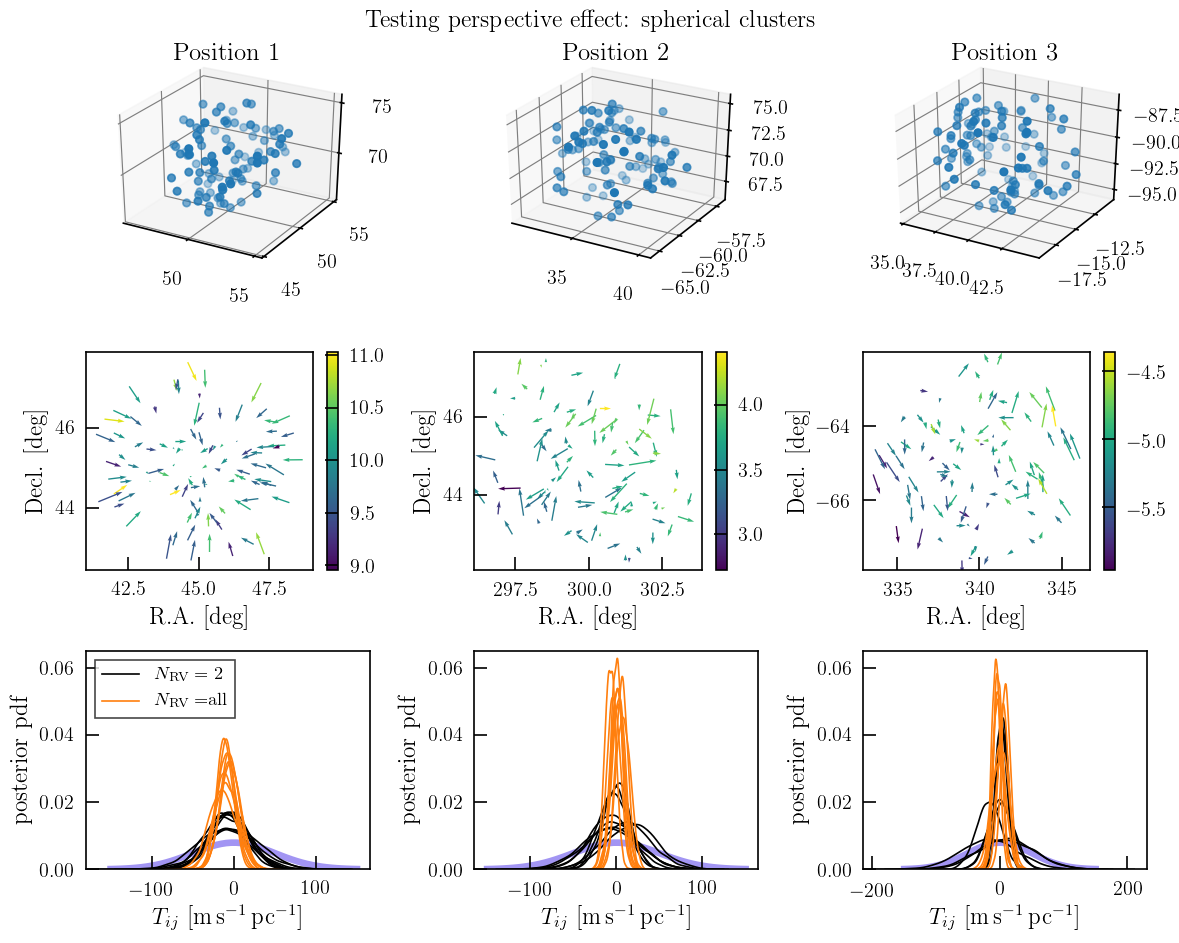

In [14]:
fig = plt.figure(figsize=(10, 8))
grid = fig.add_gridspec(3, 3)
axes1 = [fig.add_subplot(grid[0, i], projection="3d") for i in range(3)]
axes2 = [fig.add_subplot(grid[1, i]) for i in range(3)]
axes3 = [fig.add_subplot(grid[2, i]) for i in range(3)]

fig.suptitle("Testing perspective effect: spherical clusters")
for cax1, cax2, cax3, pos in zip(axes1, axes2, axes3, ["pos1", "pos2", "pos3"]):
    cl = sphere2_result[pos]["cl"]
    D = cl.members.truth
    xyz = D.g.icrs.cartesian.xyz
    vxyz = D.g.icrs.velocity.d_xyz.value
    cax1.scatter(*xyz)
    cax1.set_title("Position {}".format(pos[-1]), size=15)

    cl = sphererv_result[pos]["cl"]
    D = cl.members.observed
    q = cax2.quiver(
        D["ra"],
        D["dec"],
        D["pmra"] - np.median(D["pmra"]),
        D["pmdec"] - np.median(D["pmdec"]),
        D["radial_velocity"].values,
    )

    Tij = sphere2_result[pos]["stanfit"]["T_param"].reshape((-1, 9))
    for tt in Tij.T:
        sns.kdeplot(
            tt, c="k", ax=cax3,
        )
    Tij = sphererv_result[pos]["stanfit"]["T_param"].reshape((-1, 9))
    for tt in Tij.T:
        sns.kdeplot(
            tt, c="C1", ax=cax3,
        )
    cax3.set(
        xlabel=r"$T_{ij}$ [$\mathrm{m}\,\mathrm{s}^{-1}\,\mathrm{pc}^{-1}$]",
        ylabel="posterior pdf",
        ylim=(None, 0.065),
    )

    cax2.set(xlabel="R.A. [deg]", ylabel="Decl. [deg]")
    plt.colorbar(q, ax=cax2)
    if pos == "pos1":
        (l1,) = cax3.plot([], [], "k-")
        (l2,) = cax3.plot([], [], "C1-")
        cax3.legend(
            (l1, l2),
            (r"$N_\mathrm{RV}=2$", r"$N_\mathrm{RV}=$all"),
            loc="upper left",
            fontsize=11,
        )
    x = np.linspace(-150, 150,)
    cax3.plot(
        x,
        stats.norm.pdf(x, scale=50),
        lw=4,
        alpha=0.7,
        color="mediumslateblue",
        zorder=-50,
    )

fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.savefig('../report/plots/perspective-effect-spherical-clusters.pdf')